# Introduction
<div style="width:100%;height:6px;background-color:Black;"></div>

This example was adapted from the information found at the ChemSep homepage (http://www.chemsep.org/downloads/index.html)

### Ethanol Water separation with Benzene exhibiting multiplicity

[Link to flowsheet drawing](http://www.chemsep.org/downloads/data/Ethanol_Water_Multiplicity.png)

This example is one of the most famous in the entire literature on distillation column modeling having been studied, in one form or another, by many investigators including Magnussen et al. I.Chem.E.Symp.Series, 56 (1979), [Prokopakis and Seider AIChE J., 29, 49 (1983)](http://onlinelibrary.wiley.com/doi/10.1002/aic.690290107/abstract), and [Venkataraman and Lucia Comput.Chem.Engng., 12, 55 (1988)](https://www.sciencedirect.com/science/article/pii/0098135488850051). The column simulated here is adapted from the work of Prokopakis and Seider.

In this example the setup of a distillation column with an external condenser (not included in the flowsheet) is illustrated, as well as the use of design specifications to reach the purity requirements.

# .NET Initialization
<div style="width:100%;height:6px;background-color:Black;"></div>

In [1]:
import clr
clr.AddReference(r"..\bin\MiniSim.Core")
clr.AddReference(r"..\bin\MiniSim.FlowsheetDrawing")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet,IconTypes
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, EquilibriumStageSection
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
import MiniSim.Core.Thermodynamics as thermo
from  MiniSim.FlowsheetDrawing import FlowsheetDrawer

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

# General Objects Instantiation
<div style="width:100%;height:6px;background-color:Black;"></div>

In [4]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

# Definition of the Thermo-System
<div style="width:100%;height:6px;background-color:Black;"></div>

When an instance of the ThermodynamicSystem class is created, we can define the base method: NRTL). 
We then add three compontents from the ChemSep Database: Eethanol, Water and the entrainer Benzene. 

We can use the ListComponents(string) method of the Database object to find suitable components, and then use the exact spelling to select it from the database.

In [5]:
sys= thermo.ThermodynamicSystem("Test2","NRTL", "default")
sys.AddComponent(Database.FindComponent("Ethanol"))
sys.AddComponent(Database.FindComponent("Water"))
sys.AddComponent(Database.FindComponent("Benzene"))
Database.FillBIPs(sys)

kmolh=Unit.Make([SI.kmol],[SI.h])

sys.VariableFactory.SetOutputDimension(PhysicalDimension.Temperature, METRIC.C)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.Pressure, METRIC.mbar)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MolarFlow, kmolh)

## Analyis of the Thermo System

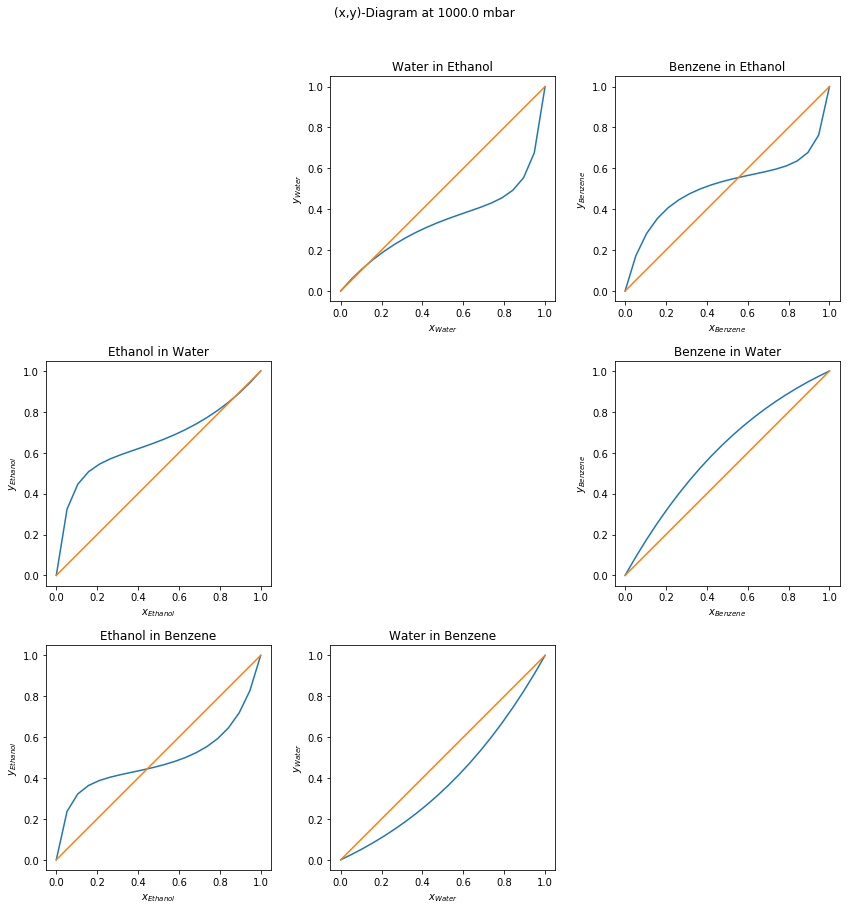

In [6]:
numComps=len(sys.Components)
names=sys.GetComponentIds()

numSteps=20
psys=1000.0
mixture= MaterialStream("Mix", sys)
mixture.Specify("VF",0.0)
mixture.Specify("P",psys, METRIC.mbar)
for c in names:
    mixture.Specify("n["+c+"]",1.0)
mixture.InitializeFromMolarFlows()
mixture.FlashPZ()

test= Flowsheet("test")
test.AddMaterialStream(mixture)

solver= num.DecompositionSolver(logger)
result=solver.Solve(test)

fig,axs=plt.subplots(numComps,numComps,figsize=(12,12))
for i in range(numComps):
    for j in range(numComps):       
        if j!=i:
            xvec=[]
            yvec=[]
            for c in range(numSteps):
                for k in range(numComps):                    
                    mixture.Specify("n["+names[k]+"]",0.0)
                mixture.Specify("n["+names[i]+"]",c/(numSteps-1))
                mixture.Specify("n["+names[j]+"]",1.0-c/(numSteps-1))
                mixture.InitializeFromMolarFlows()
                mixture.FlashPZ()
                solver.Solve(test)                               
                xvec.append(mixture.GetVariable('xL['+names[j]+']').Val())               
                yvec.append(mixture.GetVariable('xV['+names[j]+']').Val())               
            axs[i,j].plot(xvec, yvec)
            axs[i,j].plot(xvec, xvec)              
            axs[i,j].set_title(names[j] +' in '+names[i])
            axs[i,j].set_xlabel('$x_{'+names[j]+'}$')       
            axs[i,j].set_ylabel('$y_{'+names[j]+'}$')
            axs[i, j].set_aspect('equal', 'box')
        else:
            axs[i, j].axis('off')        
    
plt.tight_layout()
logger.Flush()
plt.suptitle('(x,y)-Diagram at '+str(round(psys,2))+' mbar', y=1.05);

# Flowsheet Definition
<div style="width:100%;height:6px;background-color:Black;"></div>

In [7]:
Reflux = (MaterialStream("Reflux", sys)
    .Specify("T",298, SI.K)
    .Specify("P",101.3, SI.kPa)    
    .Specify("n[Ethanol]",103.2,kmolh)
    .Specify("n[Water]",215.8,kmolh)
    .Specify("n[Benzene]",56.3,kmolh)
    .InitializeFromMolarFlows()
    .FlashPT())

Feed = (MaterialStream("Feed", sys)
    .Specify("T",311, SI.K)
    .Specify("P",102.7, SI.kPa)    
    .Specify("n[Ethanol]",85.6,kmolh)
    .Specify("n[Water]",14.4,kmolh)
    .Specify("n[Benzene]",0,kmolh)
    .InitializeFromMolarFlows()
    .FlashPT())


To check the feed specifications, we print out a preliminary flowsheet stream table.

In [8]:
flowsheet= (Flowsheet("Flow")
    .AddMaterialStreams(Feed, Reflux))
 
reporter.Report(flowsheet, 4, False)
print(logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed       Reflux

Temperature               °C              37.8500      24.8500
Pressure                  mbar          1027.0000    1013.0000
Vapor Fraction            mol/mol          0.0000       0.0000
Specific Enthalpy         kJ/kmol     -41176.7983  -42062.2306
Phase                                      Liquid       Liquid

Total Molar Flow          kmol/h         100.0000     375.3000
                  Ethanol kmol/h          85.6000     103.2000
                    Water kmol/h          14.4000     215.8000
                  Benzene kmol/h           0.0000      56.3000
Molar Composition                    
                  Ethanol mol/mol          0.8560       0.2750
                    Water mol/mol          0.1440       0.5750
                  Benzene mol/mol          0.0000       0.1500

Total Mass Flow           kg/h          4202.8785   130

After the feed streams have been defined, we declare the other process streams. To improve convergence, we initialize the column reboiler inlet stream with guessed values (we know which purity we want to achieve, and which dew-point temperature belong to that composition).

In [9]:
S03 = MaterialStream("S03",sys) #LOUT
S04 = (MaterialStream("S04",sys)
    .Init("T",373, SI.K)
    .Init("P",112.8, SI.kPa)    
    .Init("n[Ethanol]",36,kmolh)
    .Init("n[Water]",350,kmolh)
    .Init("n[Benzene]",0,kmolh)
    .InitializeFromMolarFlows()
    .FlashPT())
    
    
S05 = MaterialStream("S05",sys) #BOTTOM
S06 = MaterialStream("S06",sys) #VOUT

In [10]:
COL = (EquilibriumStageSection("COL",sys,40)
    .Connect("VIn", S04)
    .Connect("LIn", Reflux)
    .Connect("VOut", S06)
    .Connect("LOut", S03)
    .ConnectFeed(Feed,5)
    .MakeAdiabatic()
    .MakeIsobaric()
    .FixStageEfficiency(1.0)
    .Initialize(1.0,0.25,logger))

REB = (Flash("REB",sys)
    .Connect("In", S03)
    .Connect("Vap", S04)
    .Connect("Liq", S05)
    .Specify("P", 112.8, SI.kPa)
    .Specify("VF",0.70)
    .Initialize())

COL.Initialize(1.0,0.25,logger)
print (logger.Flush())

Decomposition Result: V=120, E=120, Blocks=1, Singletons=0
Block Statistics:
   # Var # Blocks % Blocks
     120        1 100,00 %
Problem Column Init was successfully solved (0,04 seconds)
Decomposition Result: V=120, E=120, Blocks=1, Singletons=0
Block Statistics:
   # Var # Blocks % Blocks
     120        1 100,00 %
Problem Column Init was successfully solved (0,01 seconds)



In [11]:
flowsheet= (Flowsheet("Flow")  
 .AddMaterialStreams(Feed, Reflux,S03,S04,S05,S06)
 .AddUnits(COL,REB)
)

# Problem Solving using Dulmage-Mendelsohn Decomposition and Newton-Raphson
<div style="width:100%;height:6px;background-color:Black;"></div>

After we have obtained an initial solution by flashing the streams and calling the Initialize methods of the column and the reboiler, we can try to solve the entire system using a Dulmage-Mendelsohn Decomposition enhanced Newton-Raphson method. In this approach, the equation system is separated into smaller independent sub-systems that are solved sequentally. As the distillation column is highly interconnected, we see that we have to solve one big block of 551 equations and variables simultaneously.

In [12]:
solver= num.DecompositionSolver(logger)
solver.SuppressNewtonLogging=True
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=708, E=708, Blocks=118, Singletons=109
Block Statistics:
   # Var # Blocks % Blocks
       1      109  92,37 %
       4        3   2,54 %
       7        4   3,39 %
       8        1   0,85 %
     551        1   0,85 %
Solving problem Subproblem 65 (Size: 551) failed!
The 10 most problematic constraints are:
TraySection          COL                                   27,825431 ( EQ000549 >> 0 := (V[32] * HV[32] + L[30] * HL[30] + F[31] * HF[31] + Q[31]) / 10000 - ((1 + RV[31]) * V[31] * HV[31] + (1 + RL[31]) * L[31] * HL[31]) / 10000 = 27,8254310950774 )
TraySection          COL                                  -11,030625 ( EQ000633 >> 0 := (V[38] * HV[38] + L[36] * HL[36] + F[37] * HF[37] + Q[37]) / 10000 - ((1 + RV[37]) * V[37] * HV[37] + (1 + RL[37]) * L[37] * HL[37]) / 10000 = -11,030624525339 )
TraySection          COL                                  -10,823695 ( EQ000619 >> 0 := (V[37] * HV[37] + L[35] * HL[35] + F[36] * HF[36] + Q[36]) / 10000 - ((1 + RV[

Sometimes the solver gets stuck and can't find a solution that fulfills the constraints on the absolute tolerance of unscaled residuals AND the norm of the step vector. When the solver is started again, it uses the intermediate solution as a starting point and can sometimes find the actual solution.

In [13]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=708, E=708, Blocks=118, Singletons=109
Block Statistics:
   # Var # Blocks % Blocks
       1      109  92,37 %
       4        3   2,54 %
       7        4   3,39 %
       8        1   0,85 %
     551        1   0,85 %
Problem NLAES was successfully solved (0,44 seconds)



## Add Design Specification: Bottom Water Purity

We want to design a column that achieves a purity of water of at least 99 mol-% in the bottom stream. We can specify that value, but then we need to add an additional degree of freedom to the problem, by unspecifying the reboiler vapor fraction.

In [14]:
S05.Specify("x[Water]",0.99)
REB.Unspecify("VF")
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=708, E=708, Blocks=120, Singletons=110
Block Statistics:
   # Var # Blocks % Blocks
       1      110  91,67 %
       4        4   3,33 %
       7        4   3,33 %
       8        1   0,83 %
     546        1   0,83 %
Problem NLAES was successfully solved (0,30 seconds)



# Flowsheet Results
<div style="width:100%;height:6px;background-color:Black;"></div>

We use the reporter object to produce a stream table for our process. The second parameter is the number of columns per page and the third parameter defines if individual phases are reported or only bulk information.

In [15]:
reporter.Report(flowsheet, 6, True)
print (logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed       Reflux          S03          S04          S05          S06

Temperature               °C              37.8500      24.8500      91.6880     100.5334     100.5334      81.1861
Pressure                  mbar          1027.0000    1013.0000    1128.0000    1128.0000    1128.0000    1128.0000
Vapor Fraction            mol/mol          0.0000       0.0000       0.0000       1.0000       0.0000       1.0000
Specific Enthalpy         kJ/kmol     -41176.7983  -42062.2306  -38455.3562    2816.5173  -38098.8613    3518.5138
Phase                                      Liquid       Liquid  LiquidVapor        Vapor  LiquidVapor  LiquidVapor

Total Molar Flow          kmol/h         100.0000     375.3000     520.5329     388.5998     131.9331     343.3669
                  Ethanol kmol/h          85.6000     103.2000      37.4002      36.0815       1.3186     18

Finally we want to look at the profiles of selected internal variables of the column. We use the GetProfile method of the Column object. It expects one or two parameters, the first is the profile type (T,TV,p,V,L), the second (optional parameter) is the component (important for profile types x,y,yeq).

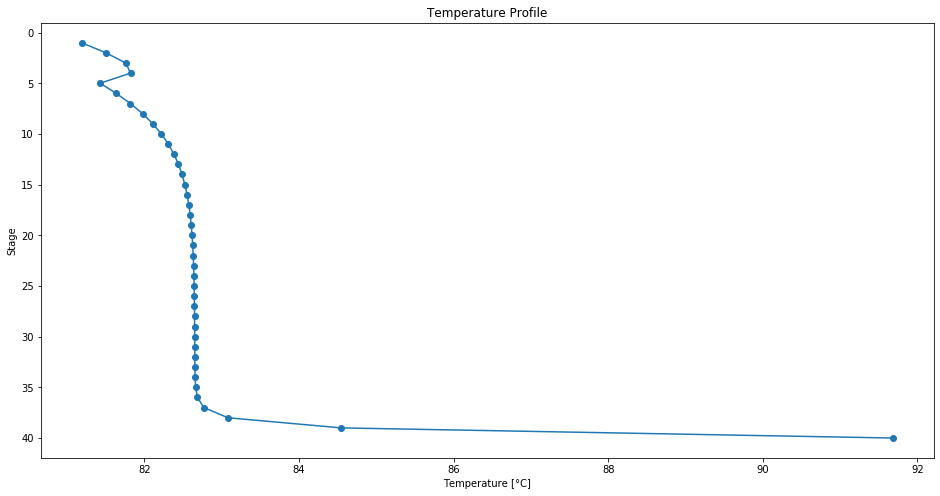

In [16]:
tprof=COL.GetProfile("T")
stages= range(1, COL.NumberOfTrays+1)
df_temp= pd.DataFrame(tprof, index=stages, columns=["T"])
plt.plot( df_temp['T'], stages,  linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.xlabel("Temperature ["+str(sys.VariableFactory.Output.UnitDictionary[PhysicalDimension.Temperature])+"]");
plt.ylabel("Stage");
plt.title("Temperature Profile");

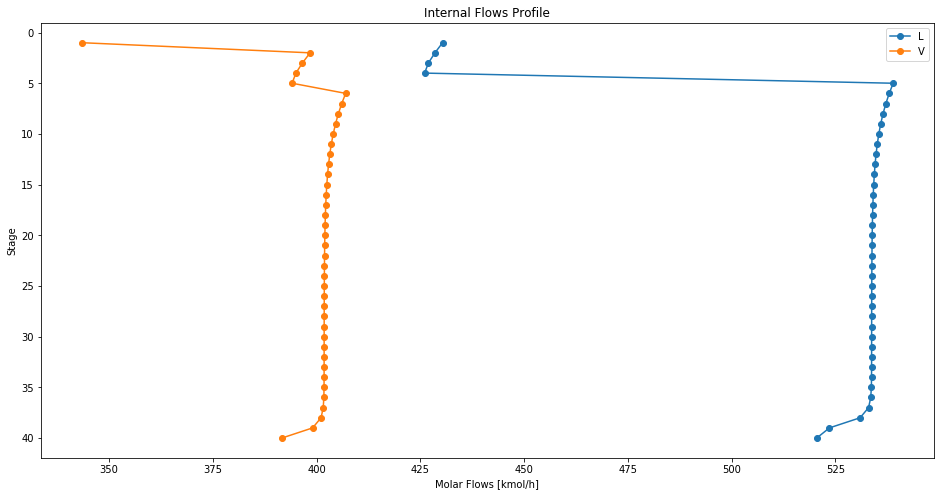

In [17]:
flows={}
flows["L"]=COL.GetProfile("L")
flows["V"]=COL.GetProfile("V")

stages= range(1, COL.NumberOfTrays+1)
df_flows= pd.DataFrame(zip(flows["L"],flows["V"]), 
                      index=stages, 
                      columns=["L","V"])

plt.plot( df_flows["L"], stages, linestyle='-', marker='o')
plt.plot( df_flows["V"], stages, linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.legend(["L","V"])
plt.xlabel("Molar Flows ["+str(sys.VariableFactory.Output.UnitDictionary[PhysicalDimension.MolarFlow])+"]")
plt.ylabel("Stage")
plt.title("Internal Flows Profile");

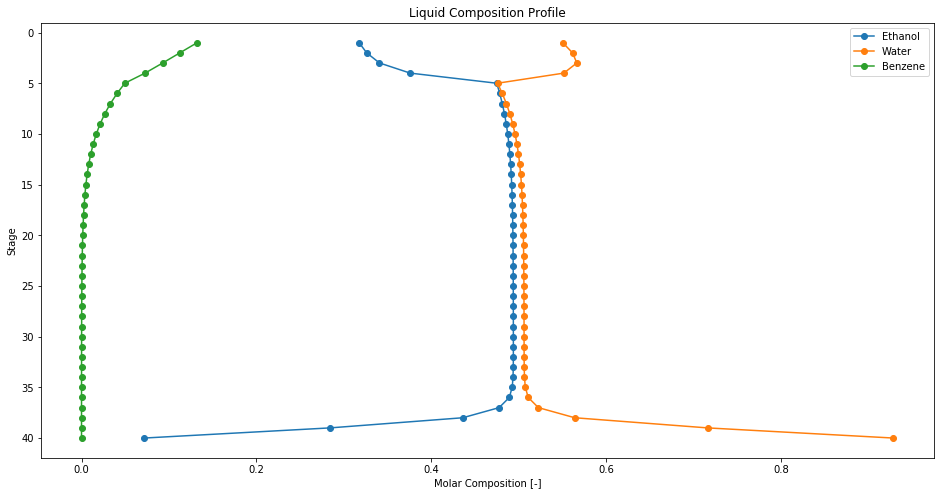

In [18]:
x={}
x["Ethanol"]=COL.GetProfile("x","Ethanol")
x["Water"]=COL.GetProfile("x","Water")
x["Benzene"]=COL.GetProfile("x","Benzene")

stages= range(1, COL.NumberOfTrays+1)
df_comp= pd.DataFrame(zip(x["Ethanol"],x["Water"],x["Benzene"] ), 
                      index=stages, 
                      columns=sys.GetComponentIds())

plt.plot( df_comp["Ethanol"], stages, linestyle='-', marker='o')
plt.plot( df_comp["Water"], stages, linestyle='-', marker='o')
plt.plot( df_comp["Benzene"], stages, linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.legend(sys.GetComponentIds())
plt.xlabel("Molar Composition [-]")
plt.ylabel("Stage")
plt.title("Liquid Composition Profile");

# Block Flow Diagram

In [19]:
from IPython.display import Image as render

def convertFlowsheet(flowsheet):
    drawer= FlowsheetDrawer()    
    return bytes(drawer.DrawAsBase64(flowsheet))  

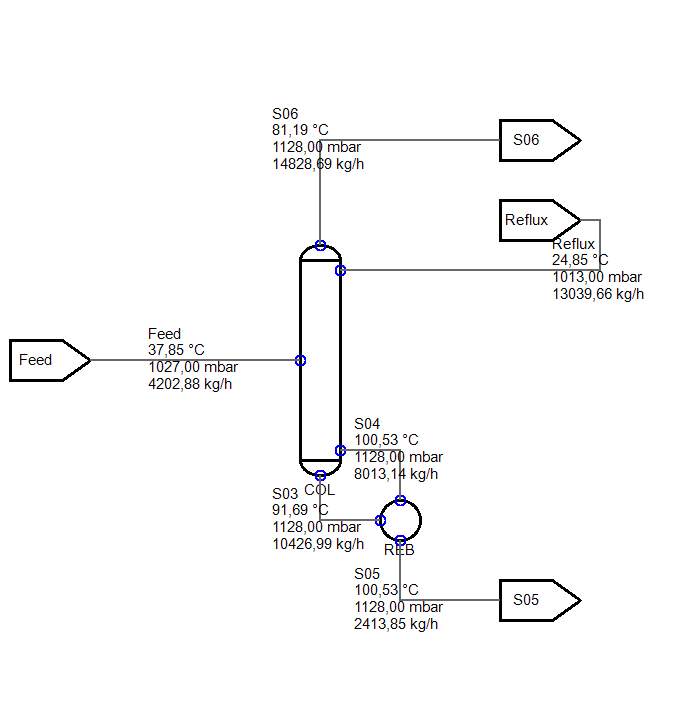

In [20]:
COL.SetIcon(IconTypes.ColumnSection, 300,260)
REB.SetIcon(IconTypes.TwoPhaseFlash, 380,500)
Feed.SetIcon(IconTypes.Stream, 10,340)
S05.SetIcon(IconTypes.Stream, 500,580)
S06.SetIcon(IconTypes.Stream, 500,120)
Reflux.SetIcon(IconTypes.Stream, 500,200)

render(convertFlowsheet(flowsheet))